# Figure 6: Denmark Strait freshwater transport adjoint sensitivities

This notebook will reproduce Figure 6 from  E. Boland et al. 2025 (doi to come). This requires input datafiles of mean ECCOv4 SSH, adjoint sensitivities and contributions to run - please see the README for details.

The datafiles were created as follows:
- eccov4_meanssh.nc, in {DATA_DIR}, was created by running calc_eccov4_meanssh.py
- Sensitivity fields adxx_{var}.0000000129.data/meta, in {EXPDIR}/{expt}, were generated from adjoint sensitivity experiments as described in Boland et al. 2026
- ecco_2dconvs_{year}*nc, in {CONTR_DIR}/{year}, were created by running convolve.py then calc_contr_bylag.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import sys
sys.path.insert(0,'/users/emmomp/Python/ECCOv4-py')
import ecco_v4_py as ecco
sys.path.insert(0,'/users/emmomp/Python')
import xadjoint as xad
import utils as ut
import calendar
from inputs import DATA_DIR, GRIDDIR, EXPDIR, eyears, CONTR_DIR, mthi, ecco_grid
import warnings
warnings.filterwarnings('ignore')

In [2]:
mths=['Mar','Jun','Sep','Dec']
adj_freq=604800
nt=260
adj_vars=['adxx_qnet','adxx_empmr','adxx_tauu','adxx_tauv']

lags=[0,-0.25,-0.5,-1.5,-4]
lag_labels=['0 to -3m lag','-3m to -6m lag','-6m to -18m lag','-18m to -4 y lag','0 to -4y lag']
lag_lengths=[lags[i]-lags[i+1] for i in range(0,len(lags)-1)]
lag_lengths=lag_lengths+[4,]

In [3]:
mean_ssh=xr.open_dataarray(f'{DATA_DIR}/eccov4_meanssh.nc')

In [4]:
ds_all={}
for mth in mths:
    ds_all[mth]={}
    for year in eyears:
        expt=f'ad_5y_denstr_horflux_fw_{mth}_noparam_7d_{year}/'
        ds_all[mth][year]=xr.open_mfdataset(f"{EXPDIR}/{expt}/adxx_*.nc")

In [5]:
ds_plot_all=[]
for iv,var in enumerate(adj_vars):
    ds_plot_exp=[]
    for mth in mths:
        ds_plot_mth=[]
        for year in eyears:
            ds_plot_year=[]
            for ilag in range(0,len(lags)-1):
                ds_plot=ds_all[mth][year][var].sel(lag_years=slice(lags[ilag+1],lags[ilag])).mean('lag_years').squeeze()
                ds_plot['lag_range']=lag_labels[ilag]
                ds_plot_year.append(ds_plot)
            ilag+=1
            ds_plot=ds_all[mth][year][var].sel(lag_years=slice(lags[-1],0)).mean('lag_years').squeeze()
            ds_plot['lag_range']=lag_labels[-1]
            ds_plot_year.append(ds_plot)
            ds_plot_mth.append(xr.concat(ds_plot_year,'lag_range'))
        ds_plot_exp.append(xr.concat(ds_plot_mth,'eyear'))
    ds_plot_exp=xr.concat(ds_plot_exp,'month')
    ds_plot_exp.name=var
    ds_plot_all.append(ds_plot_exp)
ds_plot_all=xr.merge(ds_plot_all).load()
ds_plot_all

<xarray.Dataset> Size: 101MB
Dimensions:     (tile: 13, j: 90, i: 90, eyear: 3, month: 4, lag_range: 5)
Coordinates:
  * tile        (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j           (j) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * i           (i) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * eyear       (eyear) <U4 48B '2006' '2014' '2000'
  * month       (month) <U3 48B 'Mar' 'Jun' 'Sep' 'Dec'
    fc          (month, eyear) float64 96B -8.207e+04 -6.799e+04 ... -8.126e+04
  * lag_range   (lag_range) <U16 320B '0 to -3m lag' ... '0 to -4y lag'
Data variables:
    adxx_qnet   (month, eyear, lag_range, tile, j, i) float32 25MB 0.0 ... 0.0
    adxx_empmr  (month, eyear, lag_range, tile, j, i) float32 25MB 0.0 ... 0.0
    adxx_tauu   (month, eyear, lag_range, tile, j, i) float32 25MB 0.0 ... 0.0
    adxx_tauv   (month, eyear, lag_range, tile, j, i) float32 25MB 0.0 ... 0.0

In [6]:
ds_plot_contr=[]
for year in eyears:
    ds_plot=xr.open_mfdataset(f'{CONTR_DIR}/{year}/ecco_2dconvs_{year}*nc',concat_dim='lag_range',combine='nested')
    ds_plot['exp']=[str(x) for x in ds_plot.exp.data]
    ds_plot_contr.append(ds_plot.assign_coords({'eyear':year}).swap_dims({'exp':'month'}).drop_vars('exp'))
ds_plot_contr=xr.concat(ds_plot_contr,'eyear',coords='minimal')
ds_plot_contr['wind_OCE']=ds_plot_contr['adxx_tauuXoceTAUU']+ds_plot_contr['adxx_tauvXoceTAUV']
ds_plot_contr=ds_plot_contr.stack({'ym':['month','year']}).sortby('dates')

In [7]:
xmin,xmax,ymin,ymax=(-2266791.253073855,
 3358349.2597455736,
 -2166791.253073855,
 3458349.2597455736)
proj_dict={'projection_type':'ortho','user_lon_0':-45,'user_lat_0':70}
my_projn = ccrs.Orthographic(central_longitude=-45,central_latitude=70)
[section_pt1,section_pt2]=ecco.get_section_endpoints('Denmark Strait')

In [8]:
clims=dict(zip(adj_vars,[[20e-3,20e-3,10e-3,5e-3],[5e4,3e4,1e4,4e3],[150,30,10,3.5],[150,30,10,3.5]]))

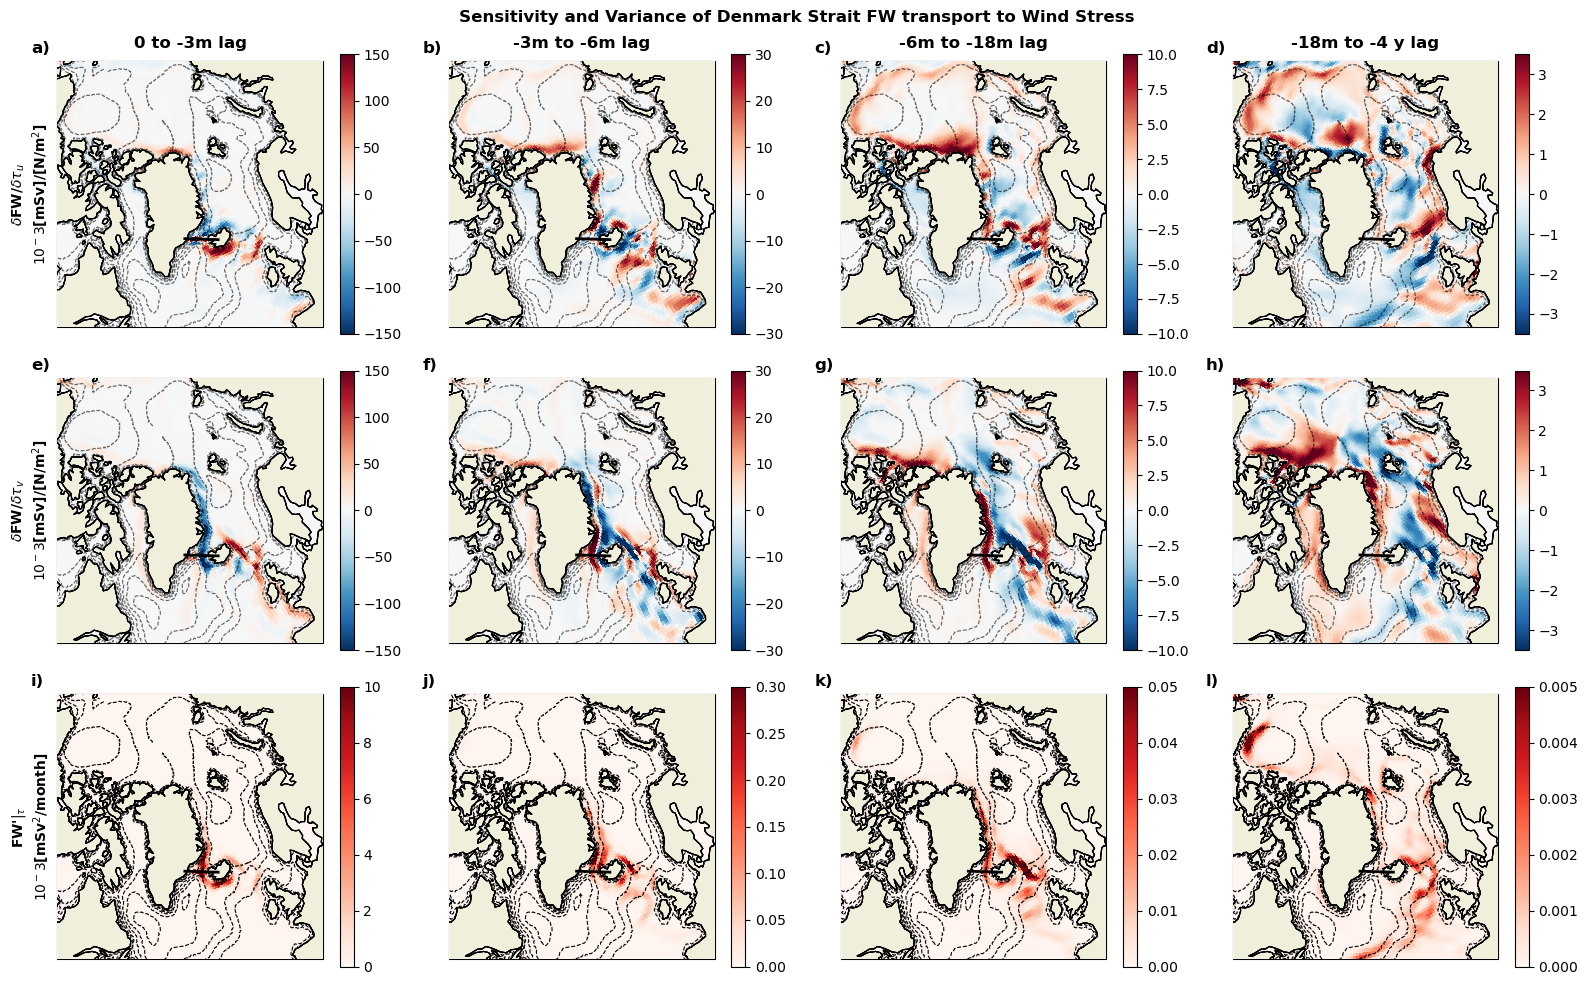

In [9]:
math_label=['$\delta$FW/$\delta \\tau_u$','$\delta$FW/$\delta \\tau_v$','FW\'$|_{\\tau}$']
var_label=['$\\sigma^2(\\tau_u)$','$\\sigma^2(\\tau_v)$']
fig=plt.figure(figsize=[16,10])
pp=1
for iv,var in enumerate(adj_vars[2:]): 
    mth_mean=-ds_plot_all[var].mean(['eyear','month'])
    for ilag in range(0,len(lags)-1):
        [f,ax,p]=ut.plot_ecco(ecco_grid,mth_mean.isel(lag_range=ilag),subplot_grid=[3,4,pp],
                           **proj_dict,rasterized=True,
                           cmin=-clims[var][ilag],cmax=clims[var][ilag]
                          )
        [f,ax,p]=ut.plot_ecco(ecco_grid,mean_ssh,ax=ax,
                                  plot_type='contour',colors='k',mapping_method='bin_average',
                                  cmap=None,negative_linestyles='dashed',linewidths=0.8,
                                  levels=np.arange(-1.4,0,0.10),show_colorbar=False,alpha=0.6,
                                  **proj_dict)
        ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)
        ax.plot([section_pt1[0],section_pt2[0]],[section_pt1[1],section_pt2[1]],
             color='k', linewidth=2,transform=ccrs.PlateCarree(),zorder=1000)
        plt.text(-0.1,1.03,f'{chr(96+pp)})',transform=plt.gca().transAxes,fontsize=12,fontweight='bold')
        if pp<5:
            plt.title(lag_labels[ilag],fontsize=12,fontweight='bold',y=1.02)
        if ilag==0:
            ax.text(-0.1,0.5,f'{math_label[iv]}\n$10^{-3}$[mSv]/[N/m$^2$]',transform=ax.transAxes,rotation='vertical',ha='center',va='center',fontweight='bold')
        pp+=1

var='wind_OCE'
clims_var=[10,0.3,0.05,0.005]
mth_mean=(ds_plot_contr[var]/1e3).var('ym').mean('eyear')*1e3
for ilag,lag in enumerate(lag_labels[:-1]):
    [f,ax,p]=ut.plot_ecco(ecco_grid,(mth_mean.sel(lag_range=lag))/(12*lag_lengths[ilag]),subplot_grid=[3,4,pp],
                       **proj_dict,cmap='Reds',rasterized=True,
                       cmin=0,cmax=clims_var[ilag]
                      )
    [f,ax,p]=ut.plot_ecco(ecco_grid,mean_ssh,ax=ax,
                        plot_type='contour',colors='k',mapping_method='bin_average',
                        cmap=None,negative_linestyles='dashed',linewidths=0.8,
                        levels=np.arange(-1.4,0,0.10),show_colorbar=False,
                        **proj_dict)
    ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)
    ax.plot([section_pt1[0],section_pt2[0]],[section_pt1[1],section_pt2[1]],
         color='k', linewidth=2,transform=ccrs.PlateCarree(),zorder=1000)
    if pp<5:
        plt.title(lag,fontsize=12,fontweight='bold')
    plt.text(-0.1,1.03,f'{chr(96+pp)})',transform=plt.gca().transAxes,fontsize=12,fontweight='bold')
    if ilag==0:
        ax.text(-0.1,0.5,f'{math_label[-1]}\n$10^{-3}$[mSv$^2$/month]',transform=ax.transAxes,rotation='vertical',ha='center',va='center',fontweight='bold')
    pp+=1
    
plt.suptitle('Sensitivity and Variance of Denmark Strait FW transport to Wind Stress ',fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig('../plots/fig6_meanwindstress_adxxvar_vslag.pdf')